## DERIVATIVES PRICER 
* Code is centered around tree-pricing models and monte carlo simulations for traditional options (European and American calls and puts) and some exotic options (Asian)

## TO DO: 

* Add vectorised MC 
* Add variance reduction methods to MC
* Show how non-closed solution american options can be priced from the base of the asian MC sim
* Add visuals for demonstrating the impact of IV on pricing

###  Future Expansion Content 
* Add GARCH models for volatility forecasts/estimates
    * May move to separate project
* Price and backtest real traded options to see the accuracy of said models in practice (ex. liquidity constraints)


* Find a proper real-life data source to create more robust examples
    * Potential Sources:
        * https://finance.yahoo.com/quote/%5ESPX/options?guce_referrer=aHR0cDovL2xvY2FsaG9zdDo4ODg4Lw&guce_referrer_sig=AQAAAJUeFD2zHulQJDrOgwLtyv-FW-lil1QsNe3h00p50uKsA4L4mKOpmN9jBZXdlzRIx2B-NivxYckMXQSwP3T3DzQyM0PdQ1t1hfrYDqgFKRRAuvBUOlS-JFjdfxwWN0U9_BHvujq_PlghcFhdQhcvnLrDonM3ti4yhPu1MD8jBksd&p=%5ESPX&straddle=false
        * https://www2.asx.com.au/markets/trade-our-derivatives-market/derivatives-market-prices/single-stock-derivatives?expiryMonths=Feb+2021&expiryMonths=Mar+2021&expiryMonths=Apr+2021&expiryMonths=May+2021&expiryMonths=Jun+2021&expiryMonths=Jul+2021&expiryMonths=Aug+2021&expiryMonths=Sep+2021&expiryMonths=Oct+2021&expiryMonths=Nov+2021&expiryMonths=Dec+2021&expiryMonths=Jan+2022&expiryMonths=Feb+2022&expiryMonths=Mar+2022&expiryMonths=Apr+2022&expiryMonths=May+2022&expiryMonths=Jun+2022&expiryMonths=Jul+2022&expiryMonths=Aug+2022&expiryMonths=Sep+2022&expiryMonths=Oct+2022&expiryMonths=Nov+2022&expiryMonths=Dec+2022&expiryMonths=Jan+2023&expiryMonths=Feb+2023&expiryMonths=Mar+2023&expiryMonths=Apr+2023&expiryMonths=May+2023&expiryMonths=Jun+2023&expiryMonths=Jul+2023&expiryMonths=Aug+2023&expiryMonths=Sep+2023&expiryMonths=Oct+2023&expiryMonths=Nov+2023&expiryMonths=Dec+2023&expiryMonths=Jan+2024&expiryMonths=Feb+2024&expiryMonths=Mar+2024&expiryMonths=Apr+2024&expiryMonths=May+2024&expiryMonths=Jun+2024&expiryMonths=Jul+2024&expiryMonths=Aug+2024&expiryMonths=Sep+2024&expiryMonths=Oct+2024&expiryMonths=Nov+2024&expiryMonths=Dec+2024&expiryMonths=Jan+2025

In [1]:
## import packages
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader.data as web
%matplotlib inline

## BLACKSCHOLES - BASELINE
* A CLOSED FORM SOLUTION FOR EUROPEAN OPTIONS

### RESTRICTIVE ASSUMPTIONS OF BLACKSCHOLES MODEL (BSM):
* Only works for European options (exercised at expiration)
* No dividends paid out during the option's life, but an optional adjustment for averaged dividend yield is possible
    * NOTE: traditional assumption is no dividends whatsoever
* No transaction or comissions costs
* Returns are log-normally distributed

### Parameters:
    * S0 = stock price
    * K = Strike
    * T = time to maturity E.G. (3/12) = 3M 
    * r = risk-free rate (discount rate)
    * sigma = volatility
    * q = (default=0) dividend % yield 

In [2]:
def blackscholes(S0, K, T, r, sigma, Type='call', q=0):
    """
    Price of a European (call or put) in the Black-Scholes model with optional dividend parameter (default=0)
    
    """
    
    d1 = (np.log(S0)-np.log(K)+((r-q)+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    
    if Type=='call':
        return S0*norm.cdf(d1)-np.exp((-r-q)*T)*K*norm.cdf(d2)

    elif Type =='put': 
        return K*np.exp((-r-q)*T)*norm.cdf(-d2) - S0*np.exp((-r-q)*T)*norm.cdf(-d1)

    # intentionally catch potential mistypes instead of just an else=put set-up
    else:
        raise TypeError("Option type is not valid, choose from: ['call','put']")

In [3]:
# hypothetical parameters:
S0=11.; K=10.; T=3/12.; r=.02; sigma=.3

In [4]:
blackscholes(S0, K, T, r, sigma, Type='call')

1.2858368491569285

In [5]:
blackscholes(S0, K, T, r, sigma, Type='put')

0.24849879216819515

### PASSING IN AN ARRAY OF STRIKES
* instead of a singular value for strike (K) - can visualise the price of the option across an array of different strike values

In [22]:
#e.g. of range of strikes
np.linspace(8, 17, 10)

array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.])

In [23]:
# pass in this array of strike values into the black scholes function to see prices
Ks = np.linspace(8, 17, 10)
blackscholes(S0, Ks, T, r, sigma, Type='call', q=0)

array([3.04764278e+00, 2.10292676e+00, 1.28583685e+00, 6.83793268e-01,
       3.15424426e-01, 1.27387743e-01, 4.57330579e-02, 1.48431228e-02,
       4.42638119e-03, 1.23061993e-03])

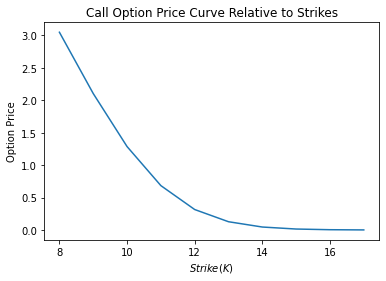

In [26]:
# plot the impact of strike (K) on prices (call)
plt.plot(Ks, blackscholes(S0, Ks, T, r, sigma, Type='call', q=0))
plt.xlabel("$Strike (K)$")
plt.ylabel("Option Price")
plt.title("Call Option Price Curve Relative to Strikes");

## IMPLIED VOLATILITY

* The *implied volatility* (IV, $\sigma _{I}$) of an option is that value of $\sigma $ which equates the BS model price to the observed market price $C_{0}^{obs}$, i.e., it solves
<br><br>
$$
C_{0}^{obs}=BS(S_{0},K,T,r,\sigma_I).
$$
<br>
* If the BS assumptions were correct, then any option traded on the asset should have the same IV, which should in turn equal historical volatility.

* In practice, options with different strikes $K$ and hence *moneyness* $K/S_{0}$ have different IVs: this gives rise to a *volatility smile* or *smirk/skew*.

    * Also, options with different times to maturity have different IVs: this yields a *volatility term structure*.

* These phenomena are evidence of a failure of the assumptions of the Black-Scholes model, most importantly that of a constant volatility $\sigma$.

In [31]:
def impvol(S0, K, T, r, C_obs, Type='call'): 
    """
    Implied Black-Scholes volatility- With Root Finding Function: Scipy Brentq
    
    """
    
    ## if != call; can convert to call price via parity
    if Type == 'put':  
        C_obs = C_obs+S0-np.exp(-r*T)*K
        
    ## else if type = call (function default behaviour)    
    # theranchi bounds
    L = -2*norm.ppf((S0-C_obs)/(2.0*min(S0, np.exp(-r*T)*K)))/np.sqrt(T)
    U = -2*norm.ppf((S0-C_obs)/(S0+np.exp(-r*T)*K))/np.sqrt(T)
    
    #Partial application would be:  f(s)=BS(S0, K, T, r, s)-C_obs.
    return brentq(lambda s: blackscholes(S0, K, T, r, s)-C_obs, L, U)  

In [32]:
## dummy data for now (C_obs = call price observed in the market)
C_obs=3 

# hypothetical parameters:
S0=11.; K=10.; T=3/12.; r=.02; sigma=.3; N=500;

In [33]:
IV = impvol(S0, K, T, r, C_obs)
print("Implied Volatility: {}".format(IV))

Implied Volatility: 1.1854766702441244


In [49]:
# equivalent to re-running the blackscholes from above with the implied volatility (IV) in place of sigma
blackscholes(S0, K, T, r, IV) # IV replaces sigma

# returns the original passed value for C_obs of ~ 3.0

3.0000000000000178

* This data is for illustrative purposes, the level of implied volatility is very high as the call option price is very high relative to the "moneyness" of the option (K/S); additionally, a high IV pushes up the value of both call and put options

## TREE OPTION PRICING 
* Specifications: 
    * Call / Put
    * American / European

In [15]:
def optiontree_flexible(S0, K, T, r, sigma, N, Type='call', option_spec='american'):
    """
    Calculate (American or European) (call & put) prices based on a N-step binomial tree: 
    """
    
    # define delta_t (Time to maturity / number of steps)
    deltaT = T / float(N)
    
    # define the factor by which the (up) movement rises
    u = np.exp(sigma*np.sqrt(deltaT))
    
    # define d in such a way the tree is recombinant 
    d = 1.0 / u
    
    # define probabilities according to the theory of risk neutral valuation
    p = (np.exp(r*deltaT)-d) / (u-d)
    
    # probabilities (up) and (down) = piu and pid respectively
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    
    # calculate the stock price tree (stock price at origination * up(down) movement factors relative to position in tree
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    
    #keep only the upper triangular part (as only non-negative payoffs contribute to price) 
    S = np.triu(S)  
    
    if Type =='call':
        
        # initialise the matrix of zeros to be written over for (when payoff > 0) for the payoff structure 
        C = np.zeros((N+1, N+1))
        
        # calculate the payoff for each node in the tree through to (N) steps: larger of (0, or stock - strike price) for call
        C[:, N] = np.maximum(0, S[:, N]-K) 

        # iterate backwards through tree to multiply payoffs by probability of being in that node
        for j in range(N-1, -1, -1):
            C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]
            
            # if option = American; calculate the value of early exercise
            if option_spec == 'american':
                C[:j+1, j] = np.maximum(K-S[:j+1, j], C[:j+1, j] )

        # return the price of the option at origination (which is the weighted sum of payoffs * probabilities) in the tree    
        return  np.round(C[0, 0],6)
    
    elif Type =='put':
        # initialise matrix of zeros (could use C again but for clarity, rename it to P)
        P = np.zeros((N+1,N+1))
        
        # calculate payoff- for put is: maximum of (0, strike-stock)
        P[:, N]=np.maximum(0, K-S[:, N])
        
        # iterate through tree of payoffs and probabilities
        for j in range(N-1, -1, -1):
            P[:j+1, j] = piu * P[:j+1, j+1] + pid * P[1:j+2, j+1]
            
            # if option = American; calculate the value of early exercise
            if option_spec =='american':
                P[:j+1, j] = np.maximum(P[:j+1, j], K-S[:j+1, j] )
    
        # return price at origination
        return  np.round(P[0, 0],6)    
    
    

In [4]:
# hypothetical parameters:
S0=11.; K=10.; T=3/12.; r=.02; sigma=.3; N=500;

In [11]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='call', option_spec='european')

1.28574

In [12]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='put', option_spec='european')

0.235864

In [13]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='call', option_spec='american')

1.522124

In [34]:
optiontree_flexible(S0, K, T, r, sigma, N, Type='put', option_spec='american')

0.236918

## INCOMPLETE !! 



# MONTE CARLO PRICING 

* The goal in Monte Carlo simulations is to obtain an estimate of (theta) denoted:

$$
\theta\equiv \mathbb{E}[X],
$$


for some random variable $X$ with finite expectation. The assumption is that we have a means of sampling from the distribution of $X$, but no closed-form expression for $\theta$. (As is the case for American options, for instance)
* Suppose we have a sample $\{X_i\}_{i\in\{1,\ldots,n\}}$ of *independent* draws for $X$, and let
$$
\bar{X}_n=\frac{1}{n}\sum_{i=1}^n X_i.
$$
* The sample average $\bar{X}_n$ is an *unbiased estimator* of $\theta$ : $\mathbb{E}[\bar{X}_n]=\theta$.
* The *weak law of large numbers* states that
$$
\bar{X}_n\stackrel p \rightarrow \theta,
$$
where the arrow denotes *convergence in probability*; i.e., as the sample size grows, $\bar X_n$ becomes a better and better estimate of $\theta$. 
    * Although, techniques exist to improve the estimate of $\theta$ without having to infinitely grow the sample size. This project will include two such techniques: 
        * Antithetic sampling 
        * Control variates 
        
        
## MC PROCESS OUTLINE:
* Thus, our strategy is to use a computer to draw $n$ (pseudo) random numbers $X_i$ from the distribution of $X$, and then estimate $\theta$ as the sample mean of the $X_i$.
* $n$ is called the number of *replications*.
* For finite $n$, the sample average will be an approximation to $\theta$. 
* It is usually desirable to have an estimate of the accuracy of this approximation. Such an estimate can be obtained from the *central limit theorem* (CLT), which states that
$$
\sqrt{n}(\bar{X}_n-\theta)\stackrel d\rightarrow N\left(0,\sigma^2\right),
$$
provided that $\sigma^2$, the variance of $X$, is finite. The arrow denotes convergence in distribution
    * this implies that for large $n$, $\bar{X}_n$ has approximately a normal distribution.
    
    
    
* Of course $\sigma^2$ is unknown, but we can estimate it in the traditional sense as
$$
\hat{\sigma}^2=\frac{1}{n}\sum_{i=1}^n \left(\bar{X}_n-X_i\right)^2.
$$

### CONFIDENCE INTERVALS IN MC SIMULATIONS: 
* A 95% *confidence interval* (CI) is an interval $[c_l,c_u]$ with
$
\mathbb{P}[c_l\leq \theta \leq c_u]=0.95.
$
* The CLT implies that, in the limit as $n\rightarrow\infty$,

\begin{align*}
\mathbb{P}[-1.96 \sigma\leq \sqrt{n}(\bar{X}_n-\theta)\leq 1.96 \sigma ]&=0.95\Leftrightarrow\\
\mathbb{P}[\bar{X}_n-1.96 \frac{\sigma}{\sqrt{n}}\leq \theta\leq \bar{X}_n+1.96 \frac{\sigma}{\sqrt{n}} ]&=0.95.
\end{align*}
* Hence $c_l=\bar{X}_n-1.96 \frac{\sigma}{\sqrt{n}}$ and $c_u=\bar{X}_n+1.96 \frac{\sigma}{\sqrt{n}}$ is an asymptotically valid CI.
* Note that $c_l$ and $c_u$ are random variables; we should interpret this as "before the experiment is performed, there is a 95% chance that a CI computed according to this formula will contain $\theta$". 
    * After performing the experiment, this statement is not valid anymore; the interval is now fixed, and contains $\theta$ with probability either 0 or 1.
* The unknown parameter $\sigma$ can be consistently estimated by $\sqrt{\hat{\sigma}^2}$.

## BRIEF INTRODUCTION TO BROWNIAN MOTION / GEOMETRIC BROWNIAN MOTION

In [ ]:
# ADD EXPLANATION

In [25]:
def bmsim(T, N, X0=0, mu=0, sigma=1):
    """Simulate a Brownian motion path with X0/mu = 0 drift terms"""
    
    deltaT = float(T)/N
    
    #N+1 is one more than we need, actually. This way we won't have to grow dX by X0.
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(N+1)   
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z  #X[j+1]-X[j]=mu*deltaT + sigma*np.sqrt(deltaT)*z[j].
    dX[0] = 0.
    X = np.cumsum(dX)
    X += X0    
    return tvec, X

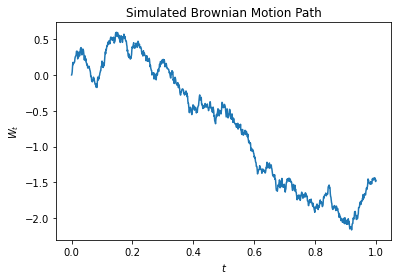

In [4]:
np.random.seed(0)
tvec, W = bmsim(1, 1000)
W = pd.Series(W, index=tvec)
W.plot()
plt.title('Simulated Brownian Motion Path')
plt.xlabel("$t$"); plt.ylabel("$W_t$");

In [20]:
def gbmsim(T, N, S0=1, mu=0, sigma=1):
    """
    Simulate a Geometric Brownian motion path with Mu (drift) = 0 and sigma = 1
    """
    
    deltaT = float(T)/N
    
    # create the linearly spaced vector of 0 through T, in increments of N + 1
    tvec = np.linspace(0, T, N+1)
    
    # initialse random numbers through N + 1 for the shape
    z = np.random.randn(N+1)  
    
    # initialise an array of zeros of the same shape (to be iterated over)
    S = np.zeros_like(z)
    
    # define the starting point for the iteration to be (1)
    S[0] = S0
    
    #Note: we can no longer vectorize this, because S[:, j] is needed for S[:, j+1].
    for i in range(0, N): 
        S[i+1] = S[i] + mu*S[i]*deltaT + sigma*S[i]*np.sqrt(deltaT)*z[i+1]
        
    return tvec, S

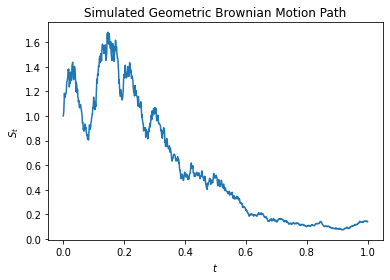

In [24]:
np.random.seed(0)
tvec, S = gbmsim(1, 1000)
S = pd.Series(S, index=tvec)
S.plot()
plt.title('Simulated Geometric Brownian Motion Path')
# x label is time; y label is stock 
plt.xlabel("$t$"); plt.ylabel("$S_t$"); 

# ASIAN OPTIONS 

* The payoff of Asian options depends on the *average* price of the underlying, $\bar{S}_T$. Types:
  * Average price Asian call with payoff $(\bar{S}_T-K)^+$;
  * Average price Asian put with payoff $(K-\bar{S}_T)^+$;
  * Average strike Asian call with payoff $(S_T-\bar{S}_T)^+$;
  * Average strike Asian put with payoff $(\bar{S}_T-S_T)^+$.


* The type of average is important in the calculation - here we consider the arithmetic average: 
$$
\qquad
\frac{1}{N}\sum_{i=1}^N S_{t_i}
$$
where the $t_i$ are a set of $N$ specified dates.

## NOTE: An exact pricing formula exists only for a geometric average asian call, hence we rely upon a MC simulation
* With the pricing formula
$$
C_{t}=e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}\left[ \left.
C_{T}\right\vert \mathcal{F}_{t}\right] 
$$


* The arithmetic average price call cannot be priced analytically, hence rely upon the MC simulation
* The asian call's payoff is: 
$$
C_T=(\bar{S}_T-K)^+,\quad\mbox{where}\quad \bar{S}_T=\frac{1}{N}\sum_{i=1}^N S_{t_i},
$$
* The payoff is *path-dependent*, so we need to simulate the entire asset price path, not just $S_T$. (the final price at maturity)


In [40]:
def asianmc(S0, K, T, r, sigma, q, N, numsim=10000):
    """
    Monte Carlo price of an arithmetic average Asian call.
    S0 = initial stock price
    K = strike price
    T = time to maturity
    r = risk-free rate (discount rate)
    sigma = volatility
    q = dividend rate 
    N = number of steps
    ## NOTE: (r-q) is the appropriate adjustment to the discount rate (r) by dividend rate (q)
    
    """
    
    # simulate the log of the stock price 
    X0 = np.log(S0)
    
    # define our drift term for brownian motion 
    nu = r-q-.5*sigma**2
    
    # simulate the shape of zeros in the form of numsim
    payoffs = np.zeros(numsim)
    
    # iterate through the number of simulations
    for i in range(numsim):
        _, X = bmsim(T, N, X0, nu, sigma) # just need (X), hence the underscore can be discarded
        
        # simulate the exponential of (X) the stock price path in the brownian motion simulation
        S = np.exp(X)
        
        # apply our payoff function: note ignore S0 (originaiton price) in the mean
        payoffs[i] = max(S[1:].mean()-K, 0.)  #We ignore S0 in the mean.
    
    # discount the payoffs 
    g = np.exp(-r*T)*payoffs
    
    # define the discounted payoffs mean and standard deviation
    C = g.mean()
    s = g.std()
    
    # define the normal distribution 97.5% percentage point function 
    zq = norm.ppf(0.975)
    
    # define our confidence interval for lower (cl) and upper(cu) (formula in markdown above)
    Cl = C-(zq*s)/np.sqrt(numsim)
    Cu = C+(zq*s)/np.sqrt(numsim)
    
    # return C (price of option) + confidence intervals 
    return C, Cl, Cu

In [38]:
%%time

# define dummy data for testing purposes:
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10

# ensure random seed for comparability
np.random.seed(0)

C0, Cl, Cu = asianmc(S0, K, T, r, sigma, q, N); C0, Cl, Cu

Wall time: 527 ms


(1.0927262054551385, 1.0747653929130998, 1.1106870179971773)

In [39]:
%timeit asianmc(S0, K, T, r, sigma, q, N)

434 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## VECTORISE THE ASIAN MC PRICER 
* compare the outputs and time to completion 

In [ ]:
## TBC 

In [5]:
#Note new input: numsim, the number of paths.
## check -- error in code when plugging into MC! 

def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=1):  
    """Simulate `numsim` Brownian motion paths."""
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(numsim, N+1)  
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    
    dX[:, 0] = 0.  
    X = np.cumsum(dX, axis=1)  
    
    X += X0    
    return tvec, X

In [ ]:
def asianmc_vec(S0, K, T, r, sigma, q, N, numsim=10000):
    """Monte Carlo price of an arithmetic average Asian call. Vectorised Version"""
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    
    #simulate all paths at once:
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
    S = np.exp(X)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)  #S[1:]->S[:, 1:], max->maximum, mean()->mean(axis=1)
    g = np.exp(-r*T)*payoffs
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

## Antithetic Sampling (Variance Reduction Technique)

In [ ]:
def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=1, av=False):
    """
    Simulate `numsim` Brownian motion paths. (Drift (mu) = 0)) 
    If av=True, then 2*`numsim` paths are returned,where paths numsim:2*numsim+1 are the antithetic paths.
    
    """
    
    deltaT = float(T)/N
    tvec = np.linspace(0, T, N+1)
    z = np.random.randn(numsim, N+1)
    if av:
        z = np.concatenate((z, -z))  #yields an array of shape (2*numsim,N+1); z stacked on -z
    dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
    dX[:, 0] = 0.
    X = np.cumsum(dX, axis=1)
    X += X0    
    return tvec, X

In [ ]:
# E.G. 

np.random.seed(0) 
tvec, W = bmsim_vec(1, 1000, numsim=3, av=True)
W = pd.DataFrame(W.transpose(), index=tvec)
W.plot().legend().remove()
plt.title('Regular and Antithetic Brownian Motion Paths')
plt.xlabel("$t$"); plt.ylabel("$W_t$");

In [ ]:
def asianmc_vec(S0, K, T, r, sigma, q, N, numsim=10000, ant_sampling=False):
    """
    Monte Carlo price of an arithmetic average Asian call. 
    
    Change: 'ant_sampling=True' to use antithetic sampling; else, 'ant_sampling=False' by default, returns regular MC method
    """
    
    X0 = np.log(S0)
    nu = r-q-.5*sigma**2    
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim, av)
    S = np.exp(X)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    g = np.exp(-r*T)*payoffs
    
    if ant_sampling:
        g = .5*(g[:numsim]+g[numsim:])
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

In [ ]:
S0 = 11; K = 10; T = 3/12.; r = 0.02; sigma = .3; q = 0.01; N = 10; numsim=10000
np.random.seed(0)
C, Cl, Cu = asianmc_vec(S0, K, T, r, sigma, q, N, numsim, av=False)
C, Cu-Cl

In [ ]:
# compare with AV
np.random.seed(0)
C, Cl, Cu = asianmc_vec(S0, K, T, r, sigma, q, N, int(numsim/2), True)  #Using int() since some function expect an integer.
C, Cu-Cl

## CONTROL VARIATES 

In [ ]:
def asiancall_geo(S0, K, T, r, sigma, q, N):
    """
    Price of a geometric average price asian call.
    
    """
    
    shat = sigma * np.sqrt(((N+1) * (2*N+1)) / (6.0 * N**2))
    mhat = shat**2/2.0 + (r-q-.5*sigma**2) * (N+1)/(2.0*N)
    
    d1 = (np.log(S0/float(K)) + T*(mhat + 0.5*shat**2)) / shat / np.sqrt(T)
    d2 = d1-shat*np.sqrt(T)
    
    price = np.exp((mhat-r)*T)*S0*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    return price

In [ ]:
def asianmc_cv(S0, K, T, r, sigma, q, N, numsim=10000):
    """
    Monte Carlo price of an arithmetic average Asian call using control variates."""
    
    # define starting point for the brownian motion as the log of stock price
    X0 = np.log(S0)
    
    # define our discounted (r-q) drift term  (functions as an "expected return" of the stock price)
    nu = r-q-.5*sigma**2    
    
    # simulate all possible stock paths originating from (X0) and with 
    _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
    
    # convert the brownian motion simulated values to prices
    S = np.exp(X)
    
    
    mu = asiancall_geo(S0, K, T, r, sigma, q, N)
    payoffs = np.maximum(S[:, 1:].mean(axis=1)-K, 0.)
    control = np.maximum(np.exp(X[:, 1:].mean(axis=1))-K, 0.)
    c = (np.cov(payoffs, control)/np.var(control))[0, 1]  #Select element (0,1) in a (2,2) var/cov-matrix.
    g = np.exp(-r*T)*payoffs - c*(np.exp(-r*T)*control-mu)
    C = g.mean(); s = g.std()
    zq = norm.ppf(0.975)
    Cl = C - zq/np.sqrt(numsim)*s
    Cu = C + zq/np.sqrt(numsim)*s
    return C, Cl, Cu

In [ ]:
np.random.seed(0)
C, Cl, Cu = asianmc_cv(S0, K, T, r, sigma, q, 10, numsim)
C, Cu-Cl

In [ ]:
%timeit asianmc_cv(S0, K, T, r, sigma, q, N, numsim)

## GREEKS
* Delta: the sensitivity of an option’s price changes relative to the changes in the underlying asset’s price.
* Gamma: the delta’s change relative to the changes in the price of the underlying asset.
* Vega: the sensitivity of an option price relative to the volatility of the underlying asset.
* Theta: the sensitivity of the option price relative to the option’s time to maturity.
* Rho: the sensitivity of the option price relative to interest rates.

In [ ]:
## TBC 

In [ ]:
def call_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
def call_rho(S,K,T,r,sigma):
    return 0.01*(K*T*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
    
def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
def put_rho(S,K,T,r,sigma):
    return 0.01*(-K*T*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))